# Topic Modeling
## Introduction
In this notebook, the goal will be to use topic modeling to find similarities between words in the corpus to try and draw out related topics. This will be accomplished using Latent Dirichlet Allocation (LDA and Non-Negative Matrix Factorization (NMF). We'll then compare the results to see which model performs better. Additionally, we can expect some overlap in the topics since many terms used on Stack Overflow are related to computer programming and thus have similarities. For example, object-oriented programming could be a topic that refers to multiple programming languages such as Java and Python, and a topic that refers to the command line could be related to Unix, the Mac terminal, or git.

In [1]:
# data analysis and manipulation
import pandas as pd
import numpy as np

# files
import pickle

# natural language processing
import nltk
from nltk import pos_tag
from nltk.tokenize import word_tokenize, sent_tokenize, RegexpTokenizer
from nltk.util import ngrams
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
import gensim.corpora as corpora

# topic modeling
from sklearn.feature_extraction import text
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF
from gensim import matutils, models, corpora, similarities
from gensim.test.utils import common_corpus
import scipy.sparse

# visualization
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

## LDA - CountVectorizer
In the notebook where we performed EDA and added stopwords make the stopwords list included in the vectorizer objects more robust, it appeared that the CountVectorizer did a better job of catching those terms that were a concatenation and/or were not actual words, so this vectorizer object will be the one that we move forward with for topic modeling. For now, we'll attempt to use LDA without using further text pre-processing methods such as lemmatization and parts of speech tagging, but that might be helpful in the future.
### Attempt With All Text
We'll try several different models here, manipulating the arguments inside the object like `num_topics` and `passes`. The former argument will be optimized when we can see that the model draws out distinct terms for each topic with little overlap that are clearly related. The latter argument can be increased to improve the terms that are extracted by the LDA model since it controls the number of loops over each document.

In [2]:
# read in the count vectorizer document-term matrix
df_cv = pd.read_pickle('df_stop_cv.pkl')
df_cv

,ab,aba,abab,ababba,abacounter,abaddressbookcreate,abaddressbookcreatewithoptions,abadressbookcreatewithoptions,abandonaudiofocus,abandoned,...,zooplanktona,zprofile,zr,zsh,zshrc,zulu,zvfzjni,zxwhat,zyst,zyx
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14086,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
14087,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
14088,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
14089,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [3]:
# a term-document matrix is one of the required inputs for the LDA model
tdm_cv = df_cv.transpose()
tdm_cv.head()

,0,1,2,3,4,5,6,7,8,9,...,14081,14082,14083,14084,14085,14086,14087,14088,14089,14090
ab,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
aba,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
abab,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
ababba,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
abacounter,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [4]:
# put the term-document matrix into a gensim format
sparse_counts = scipy.sparse.csr_matrix(tdm_cv)
corpus = matutils.Sparse2Corpus(sparse_counts)

In [5]:
# a dictionary of terms and their location are also required inputs for the LDA model
cv = pickle.load(open("cv_stop.pkl", "rb"))
id2word = dict((v, k) for k, v in cv.vocabulary_.items())

/Users/willnobles/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/base.py:310: UserWarning: Trying to unpickle estimator CountVectorizer from version 0.23.2 when using version 0.24.0. This might lead to breaking code or invalid results. Use at your own risk.
  warnings.warn(


In [6]:
# number of topics and number of passes are needed, as well
lda1 = models.LdaModel(corpus=corpus, id2word=id2word, num_topics=2, passes=10)
lda1.print_topics()

[(0,
  '0.009*"public" + 0.009*"new" + 0.009*"class" + 0.008*"string" + 0.007*"want" + 0.007*"id" + 0.007*"var" + 0.007*"return" + 0.007*"like" + 0.006*"using"'),
 (1,
  '0.009*"im" + 0.008*"like" + 0.008*"using" + 0.007*"use" + 0.007*"file" + 0.007*"code" + 0.006*"way" + 0.005*"want" + 0.005*"new" + 0.004*"know"')]

In [7]:
# LDA for num_topics = 3
lda2 = models.LdaModel(corpus=corpus, id2word=id2word, num_topics=3, passes=10)
lda2.print_topics()

[(0,
  '0.014*"class" + 0.012*"public" + 0.011*"string" + 0.010*"new" + 0.010*"return" + 0.009*"int" + 0.008*"like" + 0.008*"code" + 0.008*"method" + 0.007*"object"'),
 (1,
  '0.011*"im" + 0.010*"file" + 0.009*"using" + 0.008*"like" + 0.008*"use" + 0.007*"way" + 0.006*"application" + 0.006*"code" + 0.005*"files" + 0.005*"want"'),
 (2,
  '0.008*"want" + 0.007*"div" + 0.007*"image" + 0.007*"page" + 0.006*"view" + 0.006*"text" + 0.006*"id" + 0.006*"like" + 0.006*"code" + 0.006*"html"')]

In [8]:
# LDA for num_topics = 4
lda3 = models.LdaModel(corpus=corpus, id2word=id2word, num_topics=4, passes=10)
lda3.print_topics()

[(0,
  '0.017*"class" + 0.015*"public" + 0.014*"new" + 0.013*"string" + 0.013*"return" + 0.011*"int" + 0.010*"value" + 0.010*"function" + 0.009*"object" + 0.009*"like"'),
 (1,
  '0.009*"want" + 0.008*"div" + 0.008*"image" + 0.007*"page" + 0.007*"html" + 0.007*"using" + 0.007*"like" + 0.007*"text" + 0.006*"id" + 0.006*"code"'),
 (2,
  '0.028*"file" + 0.015*"files" + 0.012*"error" + 0.009*"git" + 0.007*"im" + 0.007*"directory" + 0.006*"version" + 0.006*"command" + 0.006*"using" + 0.006*"line"'),
 (3,
  '0.011*"im" + 0.010*"use" + 0.009*"like" + 0.009*"using" + 0.007*"way" + 0.007*"application" + 0.006*"code" + 0.006*"know" + 0.006*"want" + 0.005*"data"')]

In [9]:
# LDA for num_topics = 20
lda4 = models.LdaModel(corpus=corpus, id2word=id2word, num_topics=20, passes=10)
lda4.print_topics()

[(0,
  '0.058*"file" + 0.035*"git" + 0.030*"files" + 0.020*"branch" + 0.019*"directory" + 0.018*"changes" + 0.015*"permissions" + 0.014*"command" + 0.013*"module" + 0.012*"python"'),
 (1,
  '0.056*"div" + 0.052*"image" + 0.033*"width" + 0.031*"candidate" + 0.027*"height" + 0.023*"style" + 0.020*"css" + 0.018*"class" + 0.017*"images" + 0.015*"id"'),
 (2,
  '0.084*"double" + 0.042*"test" + 0.036*"frame" + 0.028*"jframe" + 0.028*"socket" + 0.022*"nodejs" + 0.021*"export" + 0.015*"sender" + 0.014*"cipher" + 0.013*"float"'),
 (3,
  '0.032*"app" + 0.027*"view" + 0.016*"iphone" + 0.015*"android" + 0.015*"device" + 0.014*"application" + 0.014*"ios" + 0.013*"user" + 0.012*"screen" + 0.011*"activity"'),
 (4,
  '0.044*"string" + 0.036*"data" + 0.032*"like" + 0.023*"way" + 0.022*"want" + 0.015*"using" + 0.014*"json" + 0.012*"thanks" + 0.010*"xml" + 0.009*"binary"'),
 (5,
  '0.040*"hook" + 0.027*"orm" + 0.020*"difference" + 0.019*"resolution" + 0.014*"kind" + 0.013*"high" + 0.012*"symbol" + 0.011*"

The model with 20 topics looks like it has some words that are identifiable as topics.
* **Topic 0**: Words like git, branch, changes, and merge look like they relate to git.
* **Topic 10**: The words table, select, query, and id are related to SQL.
* **Topic 18**: Words like public, class, void, and private are clearly related to Java or OOP.

We can stop here for now, and, perhaps with more text preprocessing, in the future we can draw out even clearer topics. We'll run the model one more time with a larger number of passes to see if there is an improvement.

In [10]:
# final LDA model
lda5 = models.LdaModel(corpus=corpus, id2word=id2word, num_topics=20, passes=20)
lda5.print_topics()

[(0,
  '0.057*"table" + 0.032*"query" + 0.028*"select" + 0.025*"column" + 0.022*"row" + 0.021*"id" + 0.021*"sql" + 0.017*"key" + 0.015*"database" + 0.015*"null"'),
 (1,
  '0.191*"class" + 0.038*"template" + 0.017*"red" + 0.017*"bean" + 0.017*"color" + 0.016*"classes" + 0.013*"base" + 0.013*"spring" + 0.011*"abstract" + 0.010*"font"'),
 (2,
  '0.030*"user" + 0.022*"server" + 0.019*"data" + 0.015*"application" + 0.014*"url" + 0.014*"web" + 0.014*"new" + 0.013*"request" + 0.012*"service" + 0.012*"users"'),
 (3,
  '0.066*"public" + 0.057*"new" + 0.048*"class" + 0.032*"object" + 0.028*"void" + 0.026*"return" + 0.025*"private" + 0.022*"method" + 0.020*"null" + 0.020*"static"'),
 (4,
  '0.055*"python" + 0.054*"import" + 0.039*"file" + 0.036*"module" + 0.030*"line" + 0.024*"binary" + 0.017*"path" + 0.013*"output" + 0.012*"capture" + 0.012*"subversion"'),
 (5,
  '0.067*"td" + 0.053*"token" + 0.036*"tr" + 0.028*"nsstring" + 0.025*"facebook" + 0.021*"domain" + 0.014*"checkbox" + 0.013*"authentica

## NMF - CountVectorizer
Let's also run a non-negative matrix factorization model to see what insights we can get and see if it's an improvement over the LDA model.

In [11]:
# read in the corpus
df = pd.read_pickle('df_stop.pkl')

In [12]:
nmf_model = NMF(n_components=20)
doc_word = cv.fit_transform(df.no_stop_words)
doc_topic = nmf_model.fit_transform(doc_word)

/Users/willnobles/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:312: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(("The 'init' value, when 'init=None' and "


In [13]:
# create a dataframe
df_nmf_cv = pd.DataFrame(nmf_model.components_, columns=cv.get_feature_names())
df_nmf_cv

,ab,aba,abab,ababba,abacounter,abaddressbookcreate,abaddressbookcreatewithoptions,abadressbookcreatewithoptions,abandonaudiofocus,abandoned,...,zooplanktona,zprofile,zr,zsh,zshrc,zulu,zvfzjni,zxwhat,zyst,zyx
0,0.047090,0.003691,0.000875,0.000875,0.002083,0.001060,0.001060,0.001060,0.000000,0.012444,...,0.000000,0.000770,0.002034,0.017208,0.005552,0.006269,0.000000,0.002349,0.000279,0.002827
1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000088,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,0.000355,0.000000,0.000000,0.000000,0.000000,0.000119,0.000119,0.000119,0.000000,0.000492,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.001088,0.000000,0.000000,0.000000,0.000000
4,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000476,0.000000
5,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000600,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
6,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.062965,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
7,0.001527,0.000000,0.000000,0.000000,0.000009,0.000000,0.000000,0.000000,0.000029,0.000000,...,0.000000,0.000003,0.000204,0.010089,0.000518,0.000000,0.000000,0.000000,0.000000,0.000000
8,0.006065,0.000000,0.000000,0.000000,0.000000,0.000517,0.000517,0.000517,0.001420,0.000000,...,0.000000,0.000000,0.000333,0.000000,0.000000,0.000000,0.000000,0.000678,0.000000,0.000000
9,0.000000,0.000000,0.000000,0.000000,0.000000,0.000140,0.000140,0.000140,0.000029,0.000000,...,0.000000,0.000000,0.000515,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [14]:
# look at top 10 highest ranked words for each topic
for topic in range(df_nmf_cv.shape[0]):
    tmp = df_nmf_cv.iloc[topic]
    print(f'For topic {topic+1} the words with the highest value are:')
    print(tmp.nlargest(10))
    print('\n')

For topic 1 the words with the highest value are:
im       8.720406
like     7.907382
using    6.942402
use      5.930669
code     5.900129
way      4.911575
want     4.290579
just     4.235206
ive      3.688421
know     3.419238
Name: 0, dtype: float64


For topic 2 the words with the highest value are:
object       11.701635
yaml         10.660363
html          2.489091
error         0.807002
rvm           0.574070
apple         0.544391
install       0.508359
configure     0.493008
ruby          0.421670
gcc           0.294158
Name: 1, dtype: float64


For topic 3 the words with the highest value are:
td            10.530338
class          8.296747
th             3.717193
odd            2.916050
colspan        1.785889
tr             1.176749
table          1.167768
borderleft     1.164181
width          0.381850
tdtd           0.314788
Name: 2, dtype: float64


For topic 4 the words with the highest value are:
type           9.882252
function       5.452974
return         4.947104


## Visualization
### Add Topics to the DataFrame
Now that we have our topics, we'll create a new column in the original DataFrame to label each question with its corresponding topic and corresponding topic probability (i.e. the probability that each question falls into its related topic label). We'll use the following two functions to get the dominant topic using the `get_document_topics` function from the [Gensim](https://radimrehurek.com/gensim/models/ldamodel.html) library. The topic probability can be obtained similarly since the output from the function is just a list of tuples, with the first element being the topic number and the second its associated probability.

In [15]:
def get_top_topic(model):
    """
    Gets top topic from model for each document.
    Input: model
    Output: highest probability topic assignment according to model (standardized to start with 1 instead of 0)
    """
    top_topics = []
    get_document_topics = [model.get_document_topics(item) for item in corpus]
    for topic in get_document_topics:
        # gets top topic and adds 1, because model outputs begin with 0
        top_topic = max(topic, key = lambda x: x[-1])[0]+1
        top_topics.append(top_topic)
    return top_topics

def get_top_proba(model):
    """
    Gets top topic probability from model for each document.
    Input: model
    Output: probability for highest probability topic assignment according to model 
    """
    top_probas = []
    get_document_topics = [model.get_document_topics(item) for item in corpus]
    for topic in get_document_topics:
        top_proba = max(topic, key = lambda x: x[-1])[1]
        top_probas.append(top_proba)
    return top_probas

In [16]:
# create new column for topic assignment
df['topic'] = get_top_topic(lda5)
#create new column for topic probabilities
df['topic_proba']= get_top_proba(lda5)

In [17]:
df.head()

,id,title,body,answer_count,favorite_count,score,tags,view_count,reputation,no_stop_words,topic,topic_proba
0,11227809,Why is processing a sorted array faster than a...,here is a piece of c code that seems very pecu...,13,7317.0,14772,java c++ performance optimization branch-predi...,805490,1,piece c code peculiar strange reason sorting d...,20,0.350070
1,477816,What is the correct JSON content type?,ive been messing around with json for some tim...,29,1089.0,6768,json content-type,1403837,95,ive messing json time just pushing text anybod...,9,0.393569
2,244777,Can I use comments inside a JSON file?,can i use comments inside a json file if so how,39,378.0,3437,json comments,631045,25,use comments inside json file,13,0.381383
3,208105,How do I remove a property from a JavaScript o...,say i create an object as follows var myobject...,13,539.0,2891,javascript object-properties,865544,16,say create object follows var myobject method ...,17,0.588472
4,271526,Avoiding != null statements,the idiom i use the most when programming in j...,49,1083.0,2499,java nullpointerexception null,737912,369,idiom use programming java test object null us...,4,0.412364


In [18]:
# look at some basic information regarding topics
df.topic.value_counts()

9     5285
17    2458
12     994
19     897
4      821
7      745
3      722
13     681
1      445
15     289
20     198
16     196
10     148
5       72
11      50
2       31
18      25
14      17
6        9
8        8
Name: topic, dtype: int64

In [19]:
# look at some basic information regarding probability
df.topic_proba.describe()

count    14091.000000
mean         0.470327
std          0.153007
min          0.050000
25%          0.355342
50%          0.445987
75%          0.563100
max          0.994311
Name: topic_proba, dtype: float64

In [20]:
# look at topics with high probability
df.loc[df.topic_proba >= 0.973]

,id,title,body,answer_count,favorite_count,score,tags,view_count,reputation,no_stop_words,topic,topic_proba
136,6919121,Why are there 2 ways to unstage a file in git?,sometimes git suggests git rm cached to unstag...,9,91.0,407,git git-reset git-rm,345522,1,git suggests git rm cached unstage file git re...,13,0.991283
232,11956710,git recover deleted file where no commit was m...,i deleted some files i did not commit yet i wa...,14,58.0,305,git,167112,11,deleted files did commit want reset workspace ...,13,0.975639
625,674855,Help a C# developer understand: What is a monad?,there is a lot of talk about monads these days...,6,84.0,158,c# c#-3.0 lambda monads,21429,1035,lot talk days read articles blog posts far exa...,9,0.976286
1327,2016404,git status shows modifications git checkout --...,i would like to remove all changes to my worki...,12,59.0,97,git working-copy not-revert,39510,2582,like remove changes working copy running git s...,13,0.994311
14054,1449425,What very large functional language projects a...,to begin with im virtually sold on the whole f...,11,10.0,16,open-source scala functional-programming clojure,1267,43,begin im virtually sold functional language th...,9,0.973928


In [21]:
df.loc[136].body

'sometimes git suggests git rm cached to unstage a file sometimes git reset head file when should i use which edit dcode git init initialized empty git repository in dcode git dcode touch a dcode git status on branch master initial commit untracked files use git add file to include in what will be committed a nothing added to commit but untracked files present use git add to track dcode git add a dcode git status on branch master initial commit changes to be committed use git rm cached file to unstage new file a dcode git commit m a master rootcommit a files changed insertions deletions create mode a dcode touch b dcode git status on branch master untracked files use git add file to include in what will be committed b nothing added to commit but untracked files present use git add to track dcode git add b dcode git status on branch master changes to be committed use git reset head file to unstage new file b '

### Further EDA: Relate Tags to Topics
We'll now perform some more EDA now that we have our model. We'll filter for documents with 80% probability or more and try to associate the tags with our topics. Then we'll perform some visualizations with the counts of top tags for each topic.

In [22]:
df_top80percent_proba = df[df['topic_proba'] >= 0.8]
df_top80percent_proba.topic.value_counts()

9     198
17    161
7      33
12     31
13     31
19     21
4      12
1       6
15      5
3       4
16      3
20      3
10      2
Name: topic, dtype: int64

We can see that the top four topics are topics 9, 17, 7, and 12. We'll relate the counts of tags to these topics in bar plots.

In [23]:
df_topic9 = df_top80percent_proba[df_top80percent_proba['topic'] == 9]
df_topic9.head()

,id,title,body,answer_count,favorite_count,score,tags,view_count,reputation,no_stop_words,topic,topic_proba
187,165808,Simple two-way encryption for C#,im looking for very simple encrypt and decrypt...,20,251.0,343,c# encryption,163252,174,im looking simple encrypt decrypt functionalit...,9,0.888433
195,1780599,I never really understood: what is POSIX?,what is posix i read the wikipedia article and...,10,84.0,333,linux unix posix terminology,91036,1,posix read wikipedia article read time encount...,9,0.801092
242,3441396,Defining custom attrs,i need to implement my own attributes like in ...,3,237.0,297,android android-resources android-attributes,131377,26,need implement attributes like official docume...,9,0.853026
369,3413470,What is std::move() and when should it be used?,what is it what does it do when should it be ...,4,64.0,219,c++ c++11 move-semantics,79284,1,does used good links appreciated,9,0.841656
461,641364,C# documentation generator?,is there any kind of documentation generator f...,15,100.0,191,c# visual-studio documentation-generation,140394,1,kind documentation generator c like documentat...,9,0.920712


In [24]:
# get the counts for each unique tag
counts9 = df_topic9.tags.str.split(expand=True).stack().value_counts()
counts9

java                38
c#                  37
c++                 23
.net                21
python              11
                    ..
django-templates     1
gac                  1
coding-style         1
web.xml              1
scripting            1
Length: 332, dtype: int64

In [25]:
len(counts9)

332

In [26]:
# convert the 10 most used tags to a list
counts9_list = counts9.index.tolist()[:10]
counts9_list

['java',
 'c#',
 'c++',
 '.net',
 'python',
 'android',
 'c',
 'php',
 'javascript',
 'scala']

In [27]:
actual9_list = counts9.to_list()[:10]
actual9_list

[38, 37, 23, 21, 11, 11, 10, 10, 10, 9]

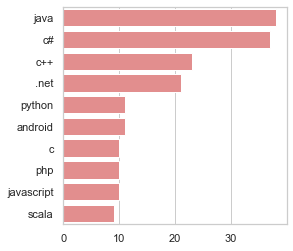

In [28]:
sns.set_theme(style="whitegrid")
fig_dims = (4, 4)
fig, ax = plt.subplots(figsize=fig_dims)
ax = sns.barplot(x=actual9_list, y=counts9_list, color='lightcoral')

We'll repeat this process for a few other tags.

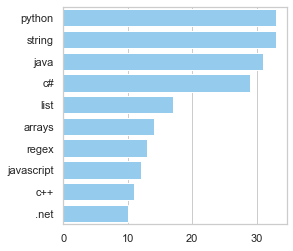

In [29]:
df_topic17 = df_top80percent_proba[df_top80percent_proba['topic'] == 17]
counts17 = df_topic17.tags.str.split(expand=True).stack().value_counts()
counts17_list = counts17.index.tolist()[:10]
actual17_list = counts17.to_list()[:10]

sns.set_theme(style="whitegrid")
fig_dims = (4, 4)
fig, ax = plt.subplots(figsize=fig_dims)
ax = sns.barplot(x=actual17_list, y=counts17_list, color='lightskyblue')

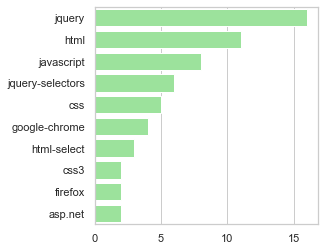

In [30]:
df_topic7 = df_top80percent_proba[df_top80percent_proba['topic'] == 7]
counts7 = df_topic7.tags.str.split(expand=True).stack().value_counts()
counts7_list = counts7.index.tolist()[:10]
actual7_list = counts7.to_list()[:10]

sns.set_theme(style="whitegrid")
fig_dims = (4, 4)
fig, ax = plt.subplots(figsize=fig_dims)
ax = sns.barplot(x=actual7_list, y=counts7_list, color='lightgreen')

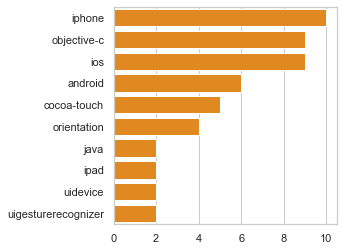

In [31]:
df_topic12 = df_top80percent_proba[df_top80percent_proba['topic'] == 12]
counts12 = df_topic12.tags.str.split(expand=True).stack().value_counts()
counts12_list = counts12.index.tolist()[:10]
actual12_list = counts12.to_list()[:10]

sns.set_theme(style="whitegrid")
fig_dims = (4, 4)
fig, ax = plt.subplots(figsize=fig_dims)
ax = sns.barplot(x=actual12_list, y=counts12_list, color='darkorange')

We can also look at the counts for each unique tag across all topics.

In [32]:
# get the counts for each unique tag
counts = df_top80percent_proba.tags.str.split(expand=True).stack().value_counts()
counts

java                  83
c#                    74
python                45
.net                  37
c++                   36
                      ..
django-templates       1
method-overloading     1
socket.io              1
capturing-group        1
ios-simulator          1
Length: 622, dtype: int64

In [33]:
len(counts)

622

In [34]:
# convert the 10 most used tags to a list
counts_list = counts.index.tolist()[:10]
counts_list

['java',
 'c#',
 'python',
 '.net',
 'c++',
 'string',
 'javascript',
 'ruby',
 'git',
 'php']

In [35]:
actual_counts = counts.to_list()[:10]
actual_counts

[83, 74, 45, 37, 36, 36, 33, 25, 22, 21]

Text(0.5, 1.0, 'Frequency of Top 10 Most Common Tags with Topic Probability > 80%')

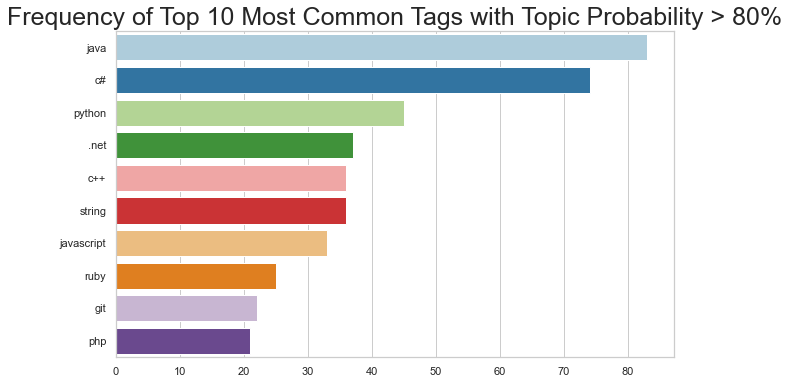

In [36]:
sns.set_theme(style="whitegrid")
fig_dims = (10, 6)
fig, ax = plt.subplots(figsize=fig_dims)
ax = sns.barplot(x=actual_counts, y=counts_list, palette='Paired')
plt.title("Frequency of Top 10 Most Common Tags with Topic Probability > 80%", fontsize=25)

### More Visualizations
Another way to visualize the unique terms within each topic is a Word Cloud. Let's make one!

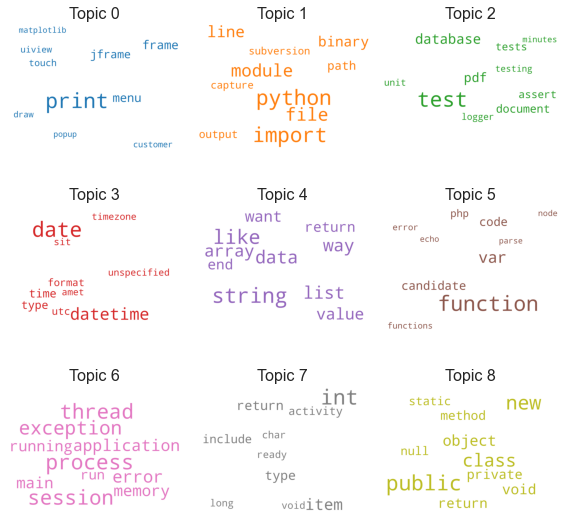

In [37]:
# wordcloud of top n words in each topic
from matplotlib import pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors

cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

cloud = WordCloud(stopwords='english',
                  background_color='white',
                  width=2500,
                  height=1800,
                  max_words=10,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

topics = lda5.show_topics(formatted=False)

fig, axes = plt.subplots(3, 3, figsize=(8,8), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
    plt.gca().axis('off')


plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

Let's try to look at the tags used according to each topic.

In [38]:
def format_topics_sentences(ldamodel, corpus, texts):
    # initialize output
    sent_topics_df = pd.DataFrame()

    # get main topic in each document
    for i, row_list in enumerate(ldamodel[corpus]):
        row = row_list[0] if ldamodel.per_word_topics else row_list            
        # print(row)
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)

df_topic_sents_keywords = format_topics_sentences(ldamodel=lda5, corpus=corpus, texts=cv.vocabulary_.items())

# format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']
df_dominant_topic.head(10)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,19.0,0.3501,"int, item, return, type, include, activity, ch...","(piece, 40638)"
1,1,8.0,0.3936,"im, use, like, using, way, code, know, ive, do...","(code, 7036)"
2,2,12.0,0.3817,"file, files, git, directory, branch, changes, ...","(peculiar, 40152)"
3,3,16.0,0.5885,"string, like, data, way, list, array, value, w...","(strange, 49401)"
4,4,3.0,0.4124,"public, new, class, object, void, return, priv...","(reason, 43526)"
5,5,3.0,0.6603,"public, new, class, object, void, return, priv...","(sorting, 48370)"
6,6,8.0,0.4883,"im, use, like, using, way, code, know, ive, do...","(data, 10189)"
7,7,8.0,0.7227,"im, use, like, using, way, code, know, ive, do...","(miraculously, 33259)"
8,8,16.0,0.3829,"string, like, data, way, list, array, value, w...","(makes, 31691)"
9,9,8.0,0.4524,"im, use, like, using, way, code, know, ive, do...","(times, 53374)"


In [39]:
# display setting to show more characters in column
pd.options.display.max_colwidth = 100

sent_topics_sorteddf_mallet = pd.DataFrame()
sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, 
                                             grp.sort_values(['Perc_Contribution'], ascending=False).head(1)], 
                                            axis=0)

# reset index    
sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)

# format
sent_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Representative Text"]

# show
sent_topics_sorteddf_mallet.head(10)

,Topic_Num,Topic_Perc_Contrib,Keywords,Representative Text
0,0.0,0.9548,"table, query, select, column, row, id, sql, key, database, null","(demo, 11485)"
1,1.0,0.5297,"class, template, red, bean, color, classes, base, spring, abstract, font","(diffs, 12219)"
2,2.0,0.8944,"user, server, data, application, url, web, new, request, service, users","(cleartextstreampush, 6771)"
3,3.0,0.9208,"public, new, class, object, void, return, private, method, null, static","(urlhttpserver, 55551)"
4,4.0,0.7103,"python, import, file, module, line, binary, path, output, capture, subversion","(decodeuricomponent, 11095)"
5,5.0,0.5611,"td, token, tr, nsstring, facebook, domain, checkbox, authenticated, pairs, cat","(httpcodejquerycomjquery, 22643)"
6,6.0,0.9672,"html, text, div, page, id, script, value, type, jquery, input","(deprecate, 11580)"
7,7.0,0.6833,"print, frame, menu, jframe, touch, uiview, draw, customer, matplotlib, popup","(separately, 46703)"
8,8.0,0.9763,"im, use, like, using, way, code, know, ive, does, question","(stage, 48927)"
9,9.0,0.8100,"function, var, candidate, code, php, error, functions, node, echo, parse","(documentlocationhash, 13121)"
